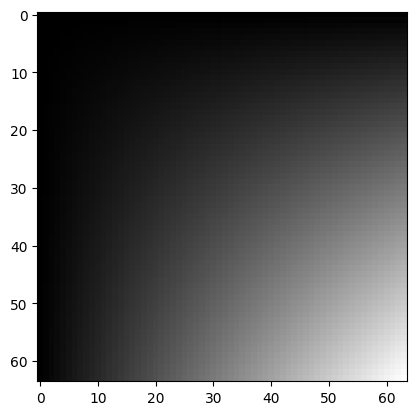

In [ ]:
#https://docs.pytorch.org/tutorials/advanced/python_custom_ops.html gonna comes back later to fix this bug

import torch
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
import PIL 
import IPython
import matplotlib.pyplot as plt 

def crop(pic, box):
    img = to_pil_image(pic.cpu())
    cropped_img = img.crop(box)
    return pil_to_tensor(cropped_img).to(pic.device) / 255

def dispplay(img):
    plt.imshow(img.numpy().transpose((1,2,0)))

img = torch.ones(3,64,64)
img *= torch.linspace(0, 1, steps=64) * torch.linspace(0, 1, steps=64).unsqueeze(-1)
display(img)


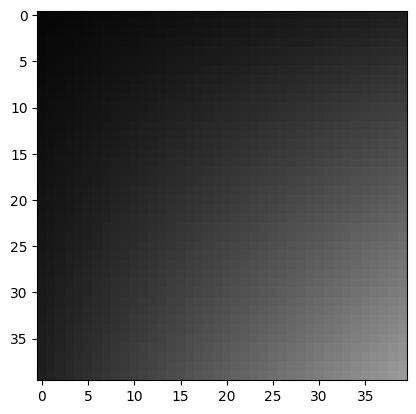

In [30]:
cropped_img = crop(img, (10,10,50,50))
display(cropped_img)

In [31]:
@torch.compile(fullgraph=True)
def f(img):
    return crop(img, (10,10,50,50))

# the following raises an error 
# cropped_img = f(img)

In [32]:
# wrap function into pytoch custom operator in order to black-box crop for use with torch.compile
from typing import Sequence 


# here we define custom operator, the operator mutates any input tensor, their name must be specified. in the mutates_args arguments
@torch.library.custom_op("my_lib::op", mutates_args=())
def crop(pic: torch.Tensor, box: Sequence[int]) -> torch.Tensor:
    img = to_pil_image(pic.cpu())
    cropped_img = img.crop(box)
    return (pil_to_tensor(cropped_img)/255.).to(pic.device, pic.dtype)

@crop.register_fake 
def _(pic,box):
    channels = pic.shape[0]
    x0, y0, x1, y1 = box 
    result = pic.new_empty(y1 - y0, x1 - x0, channels).permute(2,0,1)
    return result 
# the result should have the same metadata (shape/strides dtype /devied as running the crop function above)


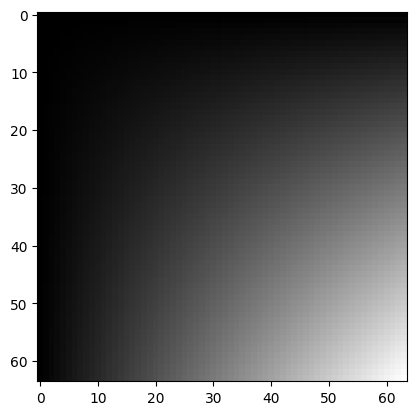

In [33]:
# because of the code above the crop now works without graph break 
def f(img):
    return crop(img, (10,10,50,50))

cropped_img = f(img)

display(img)

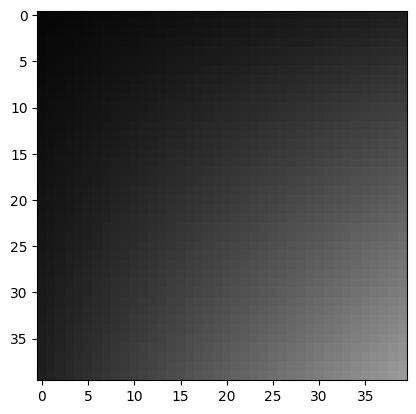

In [34]:
display(cropped_img)

In [35]:
# here we add a training support for crop

# this is prerable than use torch.autograd.Function, can cause silent incorrectness when compose with torch.compile

@torch.library.custom_op("mylib::paste", mutates_args=())
def paste(im1: torch.Tensor, im2:torch.Tensor, coord:Sequence[int]) -> torch.Tensor:
    assert im1.device() == im2.device 
    assert im1.dtype == im2.dtype 
    im1_pil = to_pil_image(im1.cpu())
    im2_pil = to_pil_image(im2.cpu())
    PIL.Image.Image.paste(im1_pil, im2_pil, coord)
    return (pil_to_tensor(im1_pil)/255.).to(im1.device, im1.dtype)

@paste.register_fake 
def _(im1, im2, coord):
    assert im1.device == im2.device 
    assert im1.dtype == im2.dtype 
    return torch.ampty_like(im1)



In [36]:
#register_autograd

def backward(ctx, grad_output):
    grad_input = grad_output.new_zeros(ctx.pic_shape)
    grad_input = paste(grad_input, grad_output, ctx.coords)
    return grad_input, None 

def setup_context(ctx, inputs, outputs):
    pic, box = inputs 
    ctx.coords = box[:2]
    ctx.pic_shape = pic.shape

crop.register_autograd(backward, setup_context=setup_context)


In [37]:
img = img.requires_grad_()

result = crop(img, (10,10,50,50))

result.sum().backward()

display(img.grad)

TypeError: setup_context() got an unexpected keyword argument 'output'

In [40]:
# testing python custom operators
examples = [
    [torch.randn(3, 64, 64), [0, 0, 10, 10]],
    [torch.randn(3, 91, 91, requires_grad=True), [10, 0, 20, 10]],
    [torch.randn(3, 60, 60, dtype=torch.double), [3, 4, 32, 20]],
    [torch.randn(3, 512, 512, requires_grad=True, dtype=torch.double), [3, 4, 32, 45]],
]

for example in examples:
    torch.library.opcheck(crop, example)

OpCheckError: opcheck(op, ...): test_schema failed with setup_context() got an unexpected keyword argument 'output' (scroll up for stack trace)

In [41]:
#mutable python custom operators

import numpy as np 

@torch.library.custom_op("my_lib::numpy_sin", mutates_args={"output"}, device_dtypes="cpu")

def numpy_sin(input: torch.Tensor, output: torch.Tensor) -> None:
    assert input.device == output.device 
    assert input.device.dtype == "cpu"
    input_np = input.numpy()
    output_np = output.numpy()
    np.sin(input_np, out=output_np)

@torch.compile(fullgraph=True)
def f(x):
    out = torch.empty(3)
    numpy_sin(x, out)
    return out
x = torch.randn(3)
y = f(x)
assert torch.allclose(y, x.sin())

TypeError: custom_op() got an unexpected keyword argument 'device_dtypes'

In [42]:
example_inputs = [
    [torch.randn(3), torch.empty(3)],
    [torch.randn(0, 3), torch.empty(0, 3)],
    [torch.randn(1, 2, 3, 4, dtype=torch.double), torch.empty(1, 2, 3, 4, dtype=torch.double)],
]

for example in example_inputs:
    torch.library.opcheck(numpy_sin, example)

NameError: name 'numpy_sin' is not defined